In [8]:
!pip install -q yahoo_fin


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import coint, adfuller
import yfinance as yf
from yahoo_fin import stock_info as si
from itertools import combinations
import requests
from bs4 import BeautifulSoup

First we are going to collect our data

In [11]:
import requests
from bs4 import BeautifulSoup

def get_energy_tickers(sector):
    # URL for Stock Analysis's list of energy sector companies
    # url = f"https://stockanalysis.com/stocks/sector/{sector}/"
    url = f"https://stockanalysis.com/stocks/industry/{sector}/"
    # url = f"https://stockanalysis.com/stocks"

    response = requests.get(url)
    html_content = response.content

    soup = BeautifulSoup(html_content, "html.parser")
    ticker_elements = soup.select("td a") # .svelte-eurwtr
    tickers = [elem.text for elem in ticker_elements]

    return tickers

def get_data_from_tickers(tickers):
     # date range to avoid COVID-19 effects I'll experiment with different years later to ensure a robust algorithm
    data = yf.download(tickers, start="2018-01-01", end="2018-06-01")
    data = data["Adj Close"]
    data = data.dropna(axis=1)
    # save all this data as a csv
    data.to_csv("stock_data_.csv")
    return data

# Call the function to get the list of energy tickers
tickers = get_energy_tickers(sector="information-technology-services")
data = get_data_from_tickers(tickers)
data.head()

[*********************100%%**********************]  60 of 60 completed

17 Failed downloads:
['ARBB', 'AUR', 'NABL', 'TASK', 'CNXC', 'CLVT', 'IBEX', 'NOTE', 'GMM', 'TWKS', 'KD', 'GDYN', 'JFU', 'PSN', 'NYAX', 'BBAI', 'CTM']: Exception("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1527825600")


Ticker,ACN,ASGN,BR,BTCM,CACI,CDW,CNDT,CSPI,CTLP,CTSH,...,SAIC,TTEC,UIS,VNET,VYX,WAVD,WIT,WNS,WYY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,139.834549,63.360001,81.668030,107.500000,134.149994,64.948296,16.540001,5.839521,9.75,65.117874,...,69.789619,34.718552,8.35,8.42,21.380367,4.2,5.563962,39.869999,6.8,21.827318
2018-01-03,140.479935,63.110001,81.596077,114.400002,137.800003,66.847595,16.250000,5.473580,9.70,65.668556,...,69.636612,34.632179,8.35,9.00,21.521473,4.2,5.524984,39.400002,6.9,21.797586
2018-01-04,142.143356,64.190002,82.243652,114.400002,136.600006,68.020676,16.270000,5.644871,9.50,66.705711,...,70.158577,34.632179,8.60,8.97,20.907974,4.2,5.505496,39.139999,6.7,22.065134
2018-01-05,143.315918,65.250000,83.251015,116.900002,137.149994,67.908943,16.160000,5.578690,9.60,67.274742,...,70.185577,34.545818,8.55,9.16,21.165644,4.2,5.417798,39.689999,6.9,22.228636
2018-01-08,144.461212,67.940002,83.763687,118.500000,138.250000,68.011368,16.459999,5.866773,9.50,67.338989,...,70.806519,35.107185,8.65,9.14,21.766870,4.1,5.524984,40.689999,6.8,22.488749


Now that we have our stocks we can process the data and input it into our algorithm

In [45]:
copy = data.copy()

In [ ]:
data = copy.copy()

In [46]:
# first check if the data has any missing values
print(data.isnull().sum().sum())
print(data.isin([np.inf, -np.inf]).sum().sum())
print(data.shape)

0
0
(104, 296)


Now that we have the data we can design a model to cluster it using a variety of techniques I will play with from DB Scan to unsupervised clustering to algorithm cocktails

In [ ]:
# make data just the first 30 stocks
# data = data.iloc[:, :30]

In [47]:
# remove all stocks under 10$
data = data.loc[:, data.iloc[-1] > 10]

In [48]:
from tqdm import tqdm

# Calculate the cointegration between all pairs of stocks
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalues, pairs = find_cointegrated_pairs(data)

100%|██████████| 224/224 [02:11<00:00,  1.71it/s]


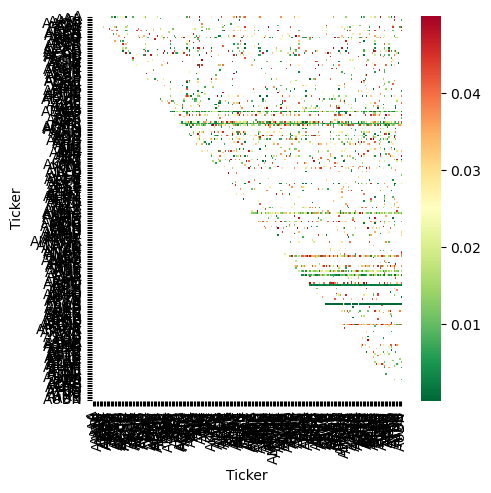

In [49]:
# show the results of the cointegration test
pvalues = pd.DataFrame(pvalues, columns=data.columns, index=data.columns)
pvalues.head()

# graph that
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.heatmap(pvalues, xticklabels=data.columns, yticklabels=data.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.05))
plt.show()

In [50]:
from tqdm import tqdm

def find_distance_between_pairs(data, pairs):
    n = len(pairs)
    distance_matrix = np.zeros((n, n))
    keys = data.keys()
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            distance = np.linalg.norm(data[pairs[i][0]] - data[pairs[j][0]])
            distance_matrix[i, j] = distance
    return distance_matrix

distance_matrix = find_distance_between_pairs(data, pairs)

# show the results of the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, columns=pairs, index=pairs)
distance_matrix.head()

100%|██████████| 2736/2736 [04:46<00:00,  9.55it/s] 


,"(A, ABM)","(A, ABTS)","(A, AC)","(A, ACB)","(A, ACGL)","(A, ACHV)","(A, ACM)","(A, ADAP)","(A, ADBE)","(A, ADUS)",...,"(ATGE, ATXI)","(ATGE, ATXS)","(ATHE, ATO)","(ATHE, ATSG)","(ATHM, ATO)","(ATHM, ATRC)","(ATHM, AUBN)","(ATNF, ATR)","(ATO, ATSG)","(ATO, AUBN)"
"(A, ABM)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.137426,189.137426,422.980477,422.980477,185.534389,185.534389,185.534389,37442.367122,84.21661,84.21661
"(A, ABTS)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.137426,189.137426,422.980477,422.980477,185.534389,185.534389,185.534389,37442.367122,84.21661,84.21661
"(A, AC)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.137426,189.137426,422.980477,422.980477,185.534389,185.534389,185.534389,37442.367122,84.21661,84.21661
"(A, ACB)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.137426,189.137426,422.980477,422.980477,185.534389,185.534389,185.534389,37442.367122,84.21661,84.21661
"(A, ACGL)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.137426,189.137426,422.980477,422.980477,185.534389,185.534389,185.534389,37442.367122,84.21661,84.21661


In [51]:
import statsmodels.api as sm

# Calculate the half life of the mean reverting series
def half_life(series):
    lag = series.shift(1)
    lag.iloc[0] = lag.iloc[1]
    ret = series - lag
    lag = sm.add_constant(lag)
    model = sm.OLS(ret, lag)
    res = model.fit()
    return -np.log(2) / res.params[1]

# Calculate the half life of the mean reverting series
def calculate_half_lives(data):
    half_lives = []
    for stock in data.columns:
        half_lives.append(np.abs(half_life(data[stock])))
    return half_lives

half_lives = calculate_half_lives(data)
half_lives = pd.DataFrame(half_lives, index=data.columns, columns=["Half Life"])
half_lives.head()

,Half Life
Ticker,
A,10.337364
AA,10.251461
AAL,36.079417
AAOI,56.736765
AAON,27.925209


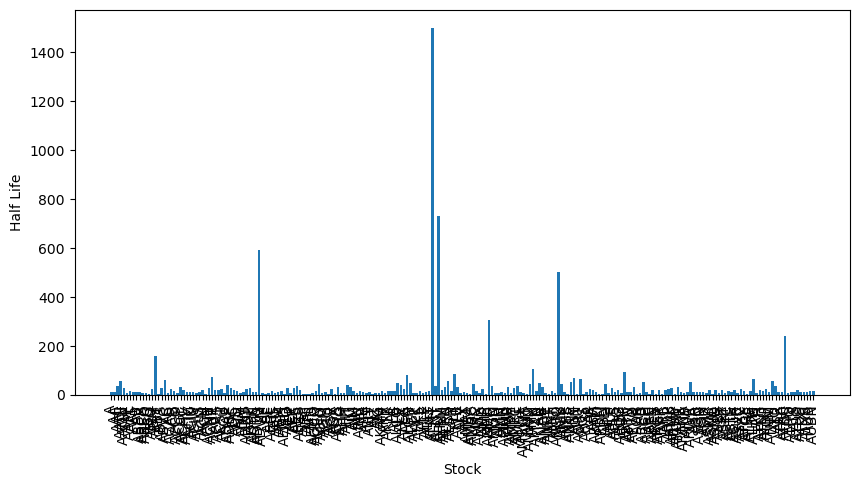

In [52]:
# plot AE
plt.figure(figsize=(10, 5))
plt.bar(half_lives.index, half_lives["Half Life"])
plt.xlabel("Stock")
plt.ylabel("Half Life")
plt.xticks(rotation=90)
plt.show()

In [53]:
# find the 5 pairs with the highest 5p-values
top_pairs = pvalues.stack().sort_values().head(5).index
top_pairs

MultiIndex([('AQB', 'ARMP'),
            ('AQB', 'ATLO'),
            ('AQB',  'ASB'),
            ('AQB', 'AROW'),
            ('AQB', 'ASMB')],
           names=['Ticker', 'Ticker'])

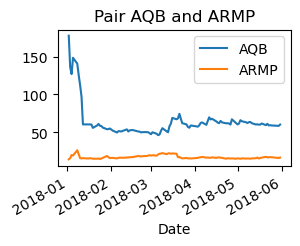

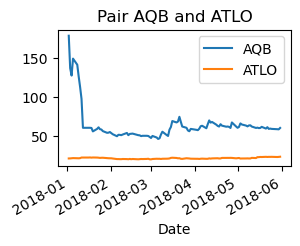

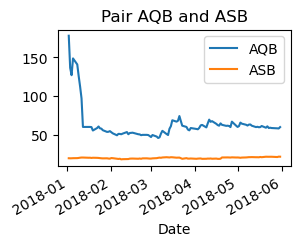

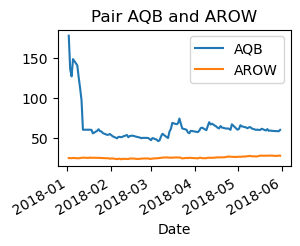

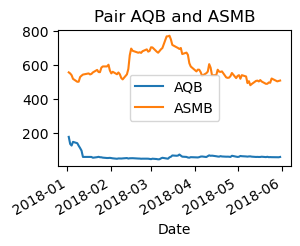

In [54]:
# plot the top 5 pairs
for pair in top_pairs:
    plt.figure(figsize=(3, 2))
    stock1, stock2 = pair
    data[pair[0]].plot(label=stock1)
    data[pair[1]].plot(label=stock2)
    plt.legend()
    plt.title(f"Pair {stock1} and {stock2}")
    plt.show()

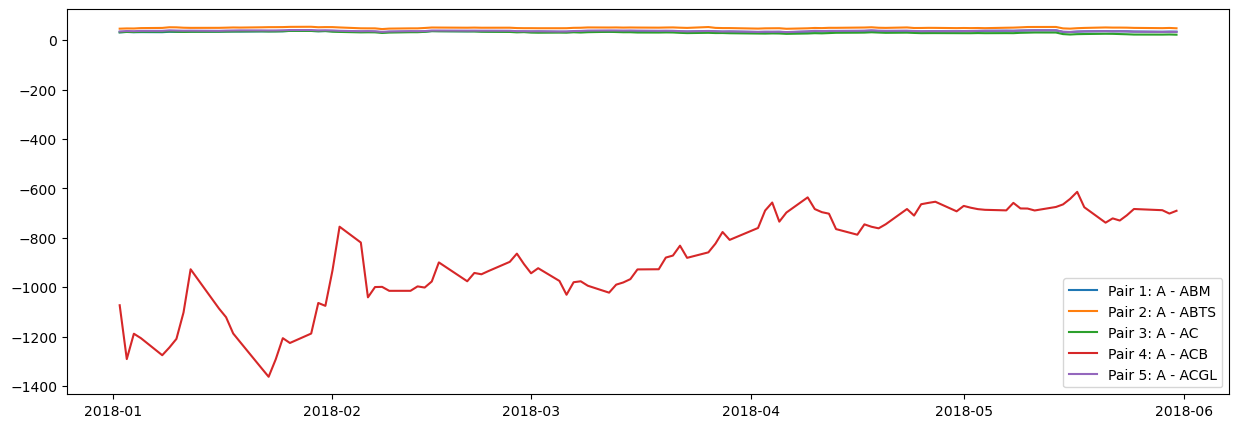

In [55]:
# graph the stock prices of the first 5 pairs of cointegrated stocks
plt.figure(figsize=(15, 5))
for i, pair in enumerate(pairs[:5]):
    plt.plot(data[pair[0]] - data[pair[1]], label=f"Pair {i+1}: {pair[0]} - {pair[1]}")
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


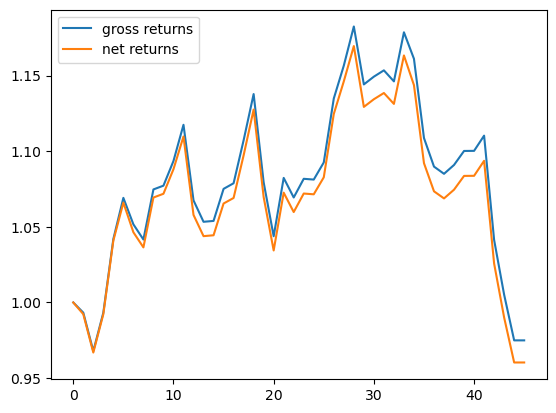

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


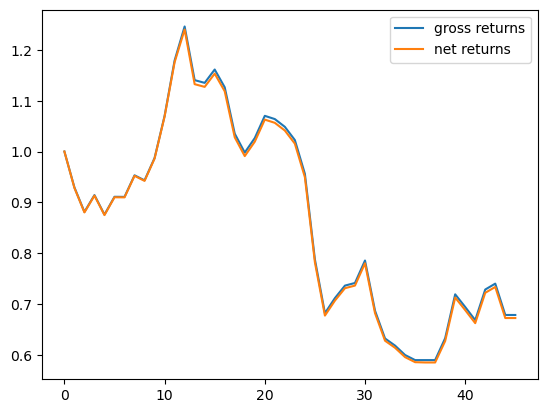

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


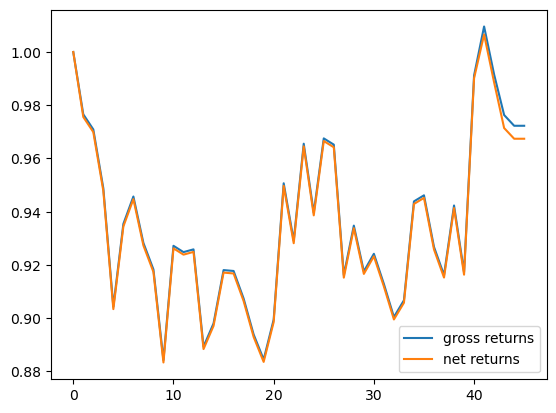

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


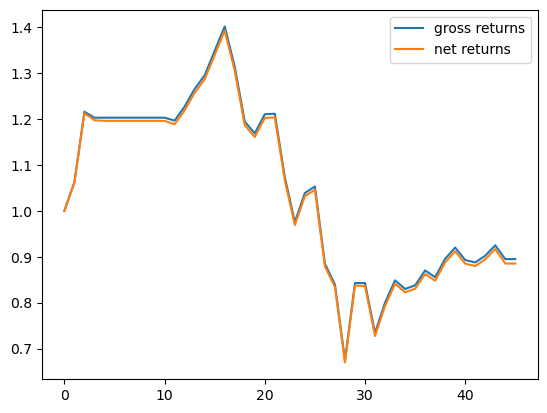

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


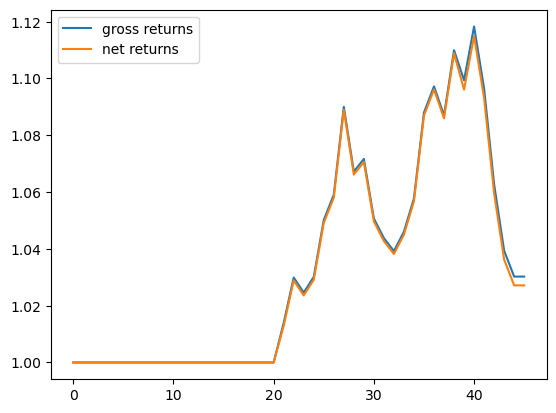

In [56]:
import TS
for pair in pairs[:5]:
    stock1, stock2 = pair
    TS.plotSim(stock1, stock2)